# Non-Parametric Statistics Workshop
Workshop done by:  
- David Plazas Escudero
- Juan Pablo Vidal
- Juan Sebastián Cárdenas-Rodríguez

## Packages and Global behavior

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as st
from math import comb
from matplotlib import cm, colors, rc
from read_data import DataAnalysis
from scipy.spatial.distance import mahalanobis as mh
from statsmodels.distributions.empirical_distribution import ECDF

%matplotlib inline
rc('text', usetex=True)

folder_fig = "figs"
dir_fig = lambda x: os.path.join(folder_fig, x)
np.random.seed(43)

def set_size(w, h, ax):
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

# Aesthetic
end = '\033[0m'
bold = '\033[1m'
header = "===================================="
n_spaces = 3

def print_results(dictionary):
    max_length = max(map(lambda x: len(x), dictionary))
    print(header)
    for key in dictionary:
        spaces_aux = n_spaces + (max_length - len(key))
        spaces = " " * spaces_aux
        print(bold + str(key) + end + spaces + str(dictionary[key]))

## Temperatures Analysis
File reading each temperatures

In [3]:
# Read file
file = open("data.txt").readlines()
file = list(map(lambda x: x.replace("\n", "").split("\t"), file))

temperatures = np.array(file, dtype=float)

Plotting of each temperature, with a linear colormap.

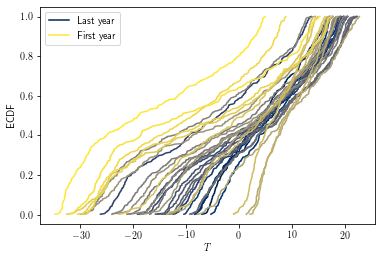

In [4]:
# First point 35 years
color1 = plt.get_cmap('cividis')
color_norm = colors.Normalize(vmin=0, vmax=temperatures.shape[1] - 1)
scalar_map = cm.ScalarMappable(norm=color_norm, cmap=color1)
legends = {0: 'Last year', temperatures.shape[1] - 1: 'First year'}
ecdfs = []
for i in range(temperatures.shape[1]):
    color = scalar_map.to_rgba(i)
    ecdf = ECDF(temperatures[:, i])
    ecdfs.append(ecdf)
    if i in legends.keys():
        plt.plot(ecdf.x, ecdf.y, color=color, label=legends[i])
    else:
        plt.plot(ecdf.x, ecdf.y, color=color)
plt.legend()
plt.xlabel("$T$")
plt.ylabel("ECDF")
plt.savefig(dir_fig("ecdfs.pdf"), bbox_inches='tight')
plt.show()

Finding and plotting the coldest and hottest year in average.

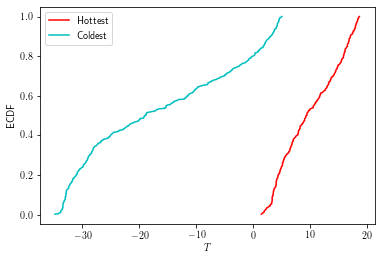

In [6]:
# Plot hottest and coldest, in average.
means = temperatures.mean(axis=0)
index_max = means.argmax()
index_min = means.argmin()

ecdf_max = ecdfs[index_max]
ecdf_min = ecdfs[index_min]

plt.plot(ecdf_max.x, ecdf_max.y, 'r', label='Hottest')
plt.plot(ecdf_min.x, ecdf_min.y, 'c', label='Coldest')
plt.legend()
plt.xlabel("$T$")
plt.ylabel("ECDF")
plt.savefig(dir_fig("ecdfs_extremes.pdf"), bbox_inches='tight')
plt.show()

### Plug-in mean estimator
Plotting of the comparison between the natural estimator and the plug-in estimator over time.

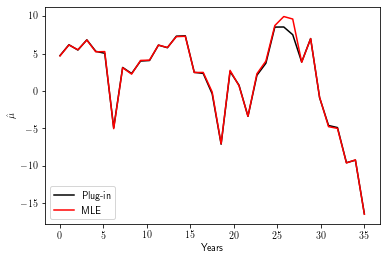

In [7]:
# Calculate the plug-in estimator
plug_in_means = []
for i in range(temperatures.shape[1]):
    ecdf = ecdfs[i]
    index_positive = np.where(ecdf.x == ecdf.x[ecdf.x >= 0][0])[0][0]
    
    positive = ecdf.y[index_positive:]
    negative = ecdf.y[:index_positive]
    
    area_positive = 0
    for j in range(len(positive) - 1):
        area_positive += (ecdf.x[j + 1 + index_positive] - ecdf.x[j + index_positive]) * (1 - positive[j])
    
    area_negative = 0
    for j in range(1, len(negative) - 1):
        area_negative += (ecdf.x[j + 1] - ecdf.x[j]) * negative[j]
    
    plug_in_means.append(area_positive - area_negative)

# Calculate MLE
means_estimated = temperatures.mean(axis = 0)

# Plotting
years = np.linspace(0, temperatures.shape[1], temperatures.shape[1])
plt.plot(years, plug_in_means, 'k', label='Plug-in')
plt.plot(years, means_estimated, 'r', label='MLE')
plt.legend()
plt.xlabel("Years")
plt.ylabel("$\hat{\mu}$")
plt.savefig(dir_fig("means.pdf"), bbox_inches='tight')
plt.show()

Plotting the data with the biggest difference

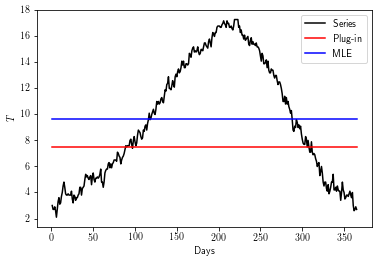

In [11]:
# Find estimators with bigger difference
max_diff = 0
max_index = 0
for i in range(len(plug_in_means)):
    if abs(plug_in_means[i] - means_estimated[i]) >= max_diff:
        max_diff = abs(plug_in_means[i] - means_estimated[i])
        max_index = i

# Plotting
length = len(temperatures[:, max_index])
days = np.linspace(1, length, length)
plug_in = np.ones(length) * plug_in_means[max_index]
mean_mle = np.ones(length) * means_estimated[max_index]

plt.plot(days, temperatures[:, max_index], 'k', label="Series")
plt.plot(days, plug_in, 'r', label="Plug-in")
plt.plot(days, mean_mle, 'b', label="MLE")
plt.xlabel("Days")
plt.ylabel("$T$")
plt.legend()
plt.show()

### Confidence bands for ECDF

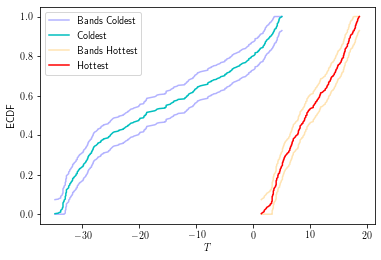

In [17]:
### Bandwidths for hottest and coldest year
alpha = 0.05
epsilon = np.sqrt(1 / (2 * temperatures.shape[0]) * np.log(2 / alpha))

def bands(ecdf):
    lower = np.zeros(len(ecdf.y))
    upper = np.zeros(len(ecdf.y))
    for i in range(len(ecdf.y)):
        lower[i] = max(ecdf.y[i] - epsilon, 0)
        upper[i] = min(ecdf.y[i] + epsilon, 1)
    return lower, upper

lower_cold, upper_cold = bands(ecdf_min)
lower_hot, upper_hot = bands(ecdf_max)

# Plotting cold
plt.plot(ecdf_min.x, lower_cold, 'b', alpha=0.3)
plt.plot(ecdf_min.x, upper_cold, 'b', alpha=0.3, label='Bands Coldest')
plt.plot(ecdf_min.x, ecdf_min.y, 'c', label='Coldest')

# Plotting hot
plt.plot(ecdf_max.x, lower_cold, 'orange', alpha=0.3)
plt.plot(ecdf_max.x, upper_cold, 'orange', alpha=0.3, label='Bands Hottest')
plt.plot(ecdf_max.x, ecdf_max.y, 'r', label='Hottest')

plt.legend()
plt.xlabel("$T$")
plt.ylabel("ECDF")
plt.savefig(dir_fig("ecdf_bands.pdf"), bbox_inches='tight')
plt.show()

## Weibull Simulation
Glivenko Cantelli theorem visualization, given by the following equation: 
  
$$\lim_{n \rightarrow \infty} \sup_x |\hat{F}_n(x) - F(x)| = 0$$

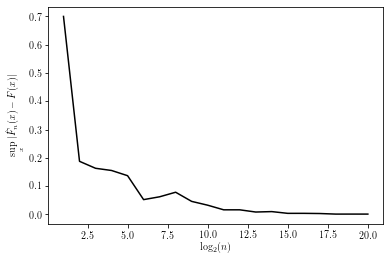

In [18]:
nums = np.linspace(1, 20, 20)
data_num = np.exp2(nums).astype(int)
params = [1.5, 0, 1]

differences = []
for i in range(len(data_num)):
    data = st.weibull_max.rvs(*params, size=data_num[i])
    ecdf = ECDF(data)
    real_weibull = st.weibull_max.cdf(ecdf.x, *params)
    
    difference = np.absolute(real_weibull - ecdf.y)
    differences.append(difference.max())

# Plotting
plt.plot(nums, differences, 'k')
plt.xlabel("$\log_2(n)$")
plt.ylabel("$$\sup_x  \,|\hat{F}_n(x) - F(x)|$$")
plt.savefig(dir_fig("weibull.pdf"), bbox_inches='tight')
plt.show()

Comparison between $j$-th statistic empirical and theoretic distribution

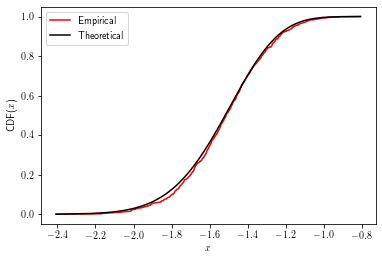

In [13]:
j = 5

# Order statistic
n = 30
params = [1.5, 0, 1]
sims = st.weibull_max.rvs(*params, size=(1000, n))

# Data for order statistic
xj = np.sort(sims, axis=1)[:, j - 1]

# Theoretical function
f_we = lambda x: st.weibull_max.cdf(x, *params)
f_th = lambda x: sum([comb(n, jp) * f_we(x) ** jp * (1 - f_we(x)) ** (n - jp) for jp in range(j, n + 1)])
ecdf = ECDF(xj)
ys_th = list(map(lambda x: f_th(x), ecdf.x[1:]))

# Plotting
plt.plot(ecdf.x, ecdf.y, 'r', label='Empirical')
plt.plot(ecdf.x[1:], ys_th, 'k', label='Theoretical')
plt.legend()
plt.xlabel("$x$")
plt.ylabel("CDF($x$)")
plt.savefig(dir_fig("order.pdf"), bbox_inches='tight')
plt.show()

## Bootstrap and Jackknife
In this section, the methods for bootstrap and jackknife can be found.

### Bootstrap

In [110]:
# Normal Bootstrap method
def normal_interval(stats, alpha, og):
    aux = (stats - np.mean(stats)) ** 2
    v_boot = 1 / len(stats) * aux.sum()
    z_alpha = st.norm.ppf(1 - alpha / 2)
    interval = (og - z_alpha*np.sqrt(v_boot), og + z_alpha*np.sqrt(v_boot))
        
    return interval, v_boot


# Percentile interval methods
def percentile_interval(stats, alpha, og):
    theta_alpha_inf = np.quantile(stats, (1 - alpha / 2))
    theta_alpha_sup = np.quantile(stats, alpha / 2)
    interval = (2*og - theta_alpha_inf, 2*og - theta_alpha_sup)

    
# Studentized pivotal interval method
def studentized_pivotal_interval(stats, statistic, n, samples, se_boot, multi, alpha, og):
    if se_boot is None:
        aux = (stats - np.mean(stats)) ** 2
        se_boot = np.sqrt(1 / len(stats) * aux.sum())
    se_bs = []
    for sample in samples:
        _, add = bootstrap(sample, n, statistic, alpha=alpha, multi=multi)
        se_bs.append(np.sqrt(add['vboot']))
    z_star = []
    for i in range(len(se_bs)):
        z_star.append((stats[i] - og) / se_bs[i] )
        
    z_alpha_1 = np.quantile(z_star, 1 - alpha / 2)
    z_alpha = np.quantile(z_star, alpha / 2)
        
    interval = (og - z_alpha_1 * se_boot, og - z_alpha * se_boot)
    
    return interval


# Bootstrap method
## 0 -> Normal interval
## 1 -> Percentile interval
## 2 -> Studentized pivotal interval
def bootstrap(series, n, statistic, alpha=0.05, method=0, multi=False, se_boot=None):
    # Calculate the statistic
    samples = []
    if multi:
        indexes = np.array(range(series.shape[1]))
        for i in range(n):
            indexes0 = np.random.choice(indexes, size=series.shape[1])
            samples.append(np.array(list(map(lambda x: series[:, x], indexes0))))
    else:
        for i in range(n):
            samples.append(np.random.choice(series, size=len(series)))
    
    stats = np.array(list(map(lambda x: statistic(x), samples)))
    og = statistic(series)
    add = {}
    
    # Calculate bootstrap respect the chosen method
    if method == 0:
        interval, v_boot = normal_interval(stats, alpha, og)
        add['vboot'] = v_boot
    elif method == 1:
        interval = percentile_interval(stats, alpha, og)
    elif method == 2:
        interval = studentized_pivotal_interval(stats, statistic, n, samples, se_boot, multi, alpha, og)
        
    return interval, add

Bootstrap method applied to the max statistic for the temperatures of the hottest year, in average.

In [32]:
temperatures_max = temperatures[:, index_max]
n = 1000
statistic = lambda x: x.max()

# Apply Bootstrap method
interval, _ = bootstrap(temperatures_max, n, statistic, method=0)
results = {"Bootstrap interval": interval, 
           "Max temperature": statistic(temperatures_max)}

print_results(results)

Bootstrap interval   (18.477565142755562, 18.72243485724444)
Max temperature      18.6


### Jackknife

In [33]:
# JackKnife method
def jackknife_bias(series, stastistic):
    og = statistic(series)
    stats = []
    for i in range(len(series)):
        t_i = np.concatenate((series[:i], series[(i+1):]))
        stats.append(statistic(t_i))
    
    t_m = np.mean(stats)
    b_jack = (len(series) - 1) * (t_m - og)
    return b_jack

def jackknife_var(series, statistic, multi=False):
    # Calculate statistics
    og = statistic(series)
    stats = []
    if multi:
        size = series.shape[1]
        for i in range(series.shape[1]):
            rows = []
            for j in range(series.shape[0]):
                rows.append(np.concatenate((series[j, :i], series[j, (i+1):])))
            t_i = np.array(rows)
            stats.append(statistic(t_i))
    else:
        size = len(series)
        for i in range(len(series)):
            t_i = np.concatenate((series[:i], series[(i+1):]))
            stats.append(statistic(t_i))
    ti_v = size * og - (size - 1) * stats
    
    # Calculate variance
    s2 = ti_v.var(ddof=1)
    return s2 / size

Jackknife method applied to the max statistic for the temperatures of the hottest year, in average.

In [35]:
b_jack = jackknife_bias(temperatures_max, statistic)
v_jack = jackknife_var(temperatures_max, statistic)

results = {"Bias Jackknife": b_jack,
           "Variance Jackknife": v_jack}
print_results(results)

Bias Jackknife       -0.09972602739917136
Variance Jackknife   7.485590393207431e-08


### Uniform and $j$-th statistic

In [37]:
# Error between theoretical and estimated values
def error(the, est):
    return abs((the - est) / the) * 100

# Generate sample
n = 10000
sample = np.random.random(size=n)
statistic = lambda x: x.max()
theoretical_bias = -1 / (n + 1)

# Calculate variance with bootstrap
_, additional = bootstrap(sample, 1000, statistic)
vboot = additional['vboot']

# Calculate bias with jackknife
bias_jack = jackknife_bias(sample, statistic)

results = {"Variance Bootstrap": vboot,
           "Theoretical bias": theoretical_bias,
           "Jackknife bias": bias_jack,
           "Error of estimation": error(theoretical_bias, bias_jack)}
print_results(results)

Variance Bootstrap    3.581529156782449e-08
Theoretical bias      -9.999000099990002e-05
Jackknife bias        -1.616658773251345e-05
Error of estimation   83.83179560871329


## Mahalanobis distance

In [51]:
# Mahalanobis distance
def mahal(u, v, inv_matrix, filename=None, method=0, plot=False, dist='chi2', params=None, ax=None):
    distance = []
    
    if method == 0:
        # Parametric
        for i in range(u.shape[1]):
            distance.append(mh(u[:, i], v, inv_matrix))
        distance = np.array(distance)

    # Comparison with Chi Square density
    distribution = getattr(st, dist)
    if params is None:
        params = distribution.fit(distance)

    if plot:
        xs = np.linspace(distribution.ppf(0.01, *params), distribution.ppf(0.99, *params), 500)
        if filename is not None:
            plt.hist(distance, color='w', ec='black', density=True)
            plt.plot(xs, distribution.pdf(xs, *params), 'r')
            plt.savefig(dir_fig(filename), bbox_inches='tight')
        else:
            if ax is None:
                plt.hist(distance, color='w', ec='black', density=True)
                plt.plot(xs, distribution.pdf(xs, *params), 'r')
                plt.show()
            else:
                ax.hist(distance, color='w', ec='black', density=True)
                ax.plot(xs, distribution.pdf(xs, *params), 'r')
    return distance


# Plotting of outliers
def plot_outliers(data, outliers, filename, ax):
    if filename is not None:
        plt.scatter(data[0, :], data[1, :], color='k', s=5)
        plt.scatter(outliers[0, :], outliers[1, :], color='r', s=5)
        plt.savefig(dir_fig(filename), bbox_inches='tight')
    else:
        if ax is None:
            plt.scatter(data[0, :], data[1, :], color='k', s=5)
            plt.scatter(outliers[0, :], outliers[1, :], color='r', s=5)
            plt.show()
        else:
            ax.scatter(data[0, :], data[1, :], c='k', s=5)
            ax.scatter(outliers[0, :], outliers[1, :], c='r', s=5)


# Remove outliers using a given distribution
def remove_outliers(data, distance, filename=None, dist='chi2', params=None, 
                    alpha=0.05, plot=False, ax=None):
    
    # Fit distribution to distance
    distribution = getattr(st, dist)
    if params is None:
        params = distribution.fit(distance)
    
    # Remove outliers using distance
    maximum_distance = distribution.ppf(1 - alpha/2, *params)
    minimum_distance = distribution.ppf(alpha/2, *params)

    outliers_max = data[:, distance > maximum_distance]
    outliers_min = data[:, distance < minimum_distance]
    
    removed_outliers = data[:, distance <= maximum_distance]
    removed_outliers = removed_outliers[:, distance[distance <= maximum_distance] >= minimum_distance]
    
    aux = []
    for i in range(outliers_min.shape[0]):
        aux.append(np.hstack((outliers_max[i, :], outliers_min[i, :])))
    outliers = np.array(aux)
    
    # Plotting of outliers
    if plot:
        plot_outliers(data, outliers, filename, ax)
        
    return removed_outliers, outliers

Generate sample. The sample is bivariate, having the data of the hottest and coldest year in average.

In [38]:
sample = np.vstack((temperatures[:, index_min], temperatures[:, index_max]))

### Methods varying the Covariance matrix
Here it can be found four different methods to calculate the mahalonobis distance.
- The first one is the usual method, which is the method non_robust
- The second one is calculating the distance using the comedian matrix and the medians vecton, which is the method comedian_method.
- The third one is calculating the distance using the spearman correlation matrix, which is the method spearman_method.
- The last one is calculating the distance using the pearson correlation matrix, which is the method kendall_method.

In [77]:
# Generic method to convert from correlation matrix to covariance matrix
def corr_to_cov(data, correlation):
    stds = data.std(axis=1, ddof=1)
    cov = np.zeros(correlation.shape)
    for i in range(correlation.shape[0]):
        for j in range(correlation.shape[1]):
            cov[i, j] = correlation[i, j] * stds[i] * stds[j]
    return cov


# Calculate inverse matrix of comedian
def calculate_inv_com(sample, medians):
    inv_com = np.zeros((medians.size, medians.size))
    for i in range(sample.shape[0]):
        for j in range(medians.size):
            diff = np.multiply(sample[i, :] - medians[i], sample[j, :] - medians[j])
            inv_com[i, j] = np.quantile(diff, 0.5)
            
    inv_com = np.linalg.inv(inv_com / (sample.shape[1] - 1))
    return inv_com


# Non-robust
def non_robust(sample, filename=None):
    inv_cov = np.linalg.inv(np.cov(sample))
    means = sample.mean(axis=1)
    if filename is not None:
        fn = "non_robust_hist_" + filename
        distance = mahal(sample, means, inv_cov, plot=True,filename=fn)
        fn = "non_robust_scatter_" + filename
        remove_outliers(sample, distance, plot=True, filename=fn)
        plt.clf()
    
    _, (ax1, ax2) = plt.subplots(1, 2)
    set_size(13, 4, ax1)
    set_size(13, 4, ax2)
    distance = mahal(sample, means, inv_cov, plot=True, ax=ax1)
    removed_outliers, outliers = remove_outliers(sample, distance, plot=True, ax=ax2)

    
# Calculate mahalonbis distance using the comedian
def comedian_method(sample, dist1, ax1, ax2, filename, fitting=True, params=None):
    da = DataAnalysis()
    # Median and comedian
    medians = np.quantile(sample, 0.5, axis=1)
    inv_com = calculate_inv_com(sample, medians)
    
    # Save figures if needed
    if filename is not None:
        fn = "comedian_hist_" + filename
        distance = mahal(sample, medians, inv_com, plot=True, dist=dist1, filename=fn, params=params)
        
        fn = "comedian_scatter_" + filename
        remove_outliers(sample, distance, plot=True, dist=dist1, filename=fn, params=params)
        plt.clf()
    else:
        distance = mahal(sample, medians, inv_com, plot=True, ax=ax1, dist=dist1, params=params)
        if fitting:
            da.set_data(distance)
            da.fitting_test(rank=1, show=True)

        # Remove outliers
        removed_outliers, outliers = remove_outliers(sample, distance, plot=True, 
                                                     ax=ax2, dist=dist1, params=params)

    
# Calculate mahalonobis distance using spearman
def spearman_method(sample, dist2, ax3, ax4, filename, fitting=True, params=None):
    da = DataAnalysis()
    # Median
    medians = np.quantile(sample, 0.5, axis=1)
    
    # Calculate Spearman
    spearman = pd.DataFrame(sample.transpose()).corr(method="spearman").to_numpy()
    cov_sp = corr_to_cov(sample, spearman)
    
    # Save figures if needed
    if filename is not None:
        fn = "spearman_hist_" + filename
        distance = mahal(sample, medians, np.linalg.inv(cov_sp), plot=True, dist=dist2, 
                         filename=fn, params=params)
        
        fn = "spearman_scatter_" + filename
        remove_outliers(sample, distance, plot=True, dist=dist2, filename=fn, params=params)
        plt.clf()
    else:
        distance = mahal(sample, medians, np.linalg.inv(cov_sp), plot=True, ax=ax3, dist=dist2, params=params)
        if fitting:
            da.set_data(distance)
            da.fitting_test(rank=1, show=True)

        removed_outliers, outliers = remove_outliers(sample, distance, plot=True, ax=ax4, dist=dist2, 
                                                     params=params)


# Calculate mahalonobis distance using kendall
def kendall_method(sample, dist3, ax5, ax6, filename, fitting=True, params=None):
    da = DataAnalysis()
    # Median
    medians = np.quantile(sample, 0.5, axis=1)
    
    # Calculate Kendall
    kendall = pd.DataFrame(sample.transpose()).corr(method="kendall").to_numpy()
    cov_k = corr_to_cov(sample, kendall)
    
    if filename is not None:
        fn = "kendall_hist_" + filename
        distance = mahal(sample, medians, np.linalg.inv(cov_k), plot=True, dist=dist3, filename=fn, 
                         params=params)

        fn = "kendall_scatter_" + filename
        remove_outliers(sample, distance, plot=True, dist=dist3, filename=fn)
        plt.clf()
    else:
        distance = mahal(sample, medians, np.linalg.inv(cov_k), plot=True, ax=ax5, dist=dist3, params=params)
        if fitting:
            da.set_data(distance)
            da.fitting_test(rank=1, show=True)

        removed_outliers, outliers = remove_outliers(sample, distance, plot=True, dist=dist3, ax=ax6, 
                                                     params=params)

Use the non-robust method to eliminate outliers in the defined sample.

<Figure size 432x288 with 0 Axes>

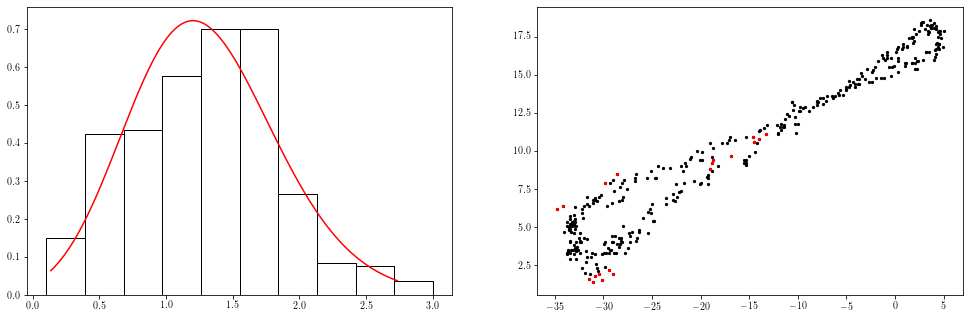

In [44]:
non_robust(sample, filename="no-noise.pdf")
plt.show()

Method to call all three robust methods.

In [78]:
# Method to analyze outliers using robust methods
def analysis_outliers(sample, dist1='chi2', dist2='genlogistic', dist3='genlogistic', 
                      params1=None, params2=None, params3=None, filename=None, fitting=True):
    if filename is not None:
        comedian_method(sample, dist1, None, None, filename)
        spearman_method(sample, dist2, None, None, filename)
        kendall_method(sample, dist3, None, None, filename)
    
    # Axes size
    _, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
    set_size(13, 14, ax1)
    set_size(13, 14, ax2)
    set_size(13, 14, ax3)
    set_size(13, 14, ax4)
    set_size(13, 14, ax5)
    set_size(13, 14, ax6)
    
    # Call three robust methods
    comedian_method(sample, dist1, ax1, ax2, None, fitting=fitting, params=params1)
    spearman_method(sample, dist2, ax3, ax4, None, fitting=fitting, params=params2)
    kendall_method(sample, dist3, ax5, ax6, None, fitting=fitting, params=params3)

Call robust methods on the defined sample. The first graph corresponds to the comedian method, the second one to the spearman and the third one to the pearson.

1. ncf          DO NOT REJECT
		P-value for test 0.2622476253486476
		Parameters       [0.01687548831480742, 17.239695538286078, 26.541605824072157, -0.16212434800608705, 0.026204105994287116]
1. powerlognorm DO NOT REJECT
		P-value for test 0.3936884169525032
		Parameters       [543.7709069217824, 0.6214705751743547, -0.9375471875010688, 13.662467507857233]
1. loggamma     DO NOT REJECT
		P-value for test 0.2880282532467704
		Parameters       [20.07659805815092, -4.88556187496933, 1.9903081462053662]


<Figure size 432x288 with 0 Axes>

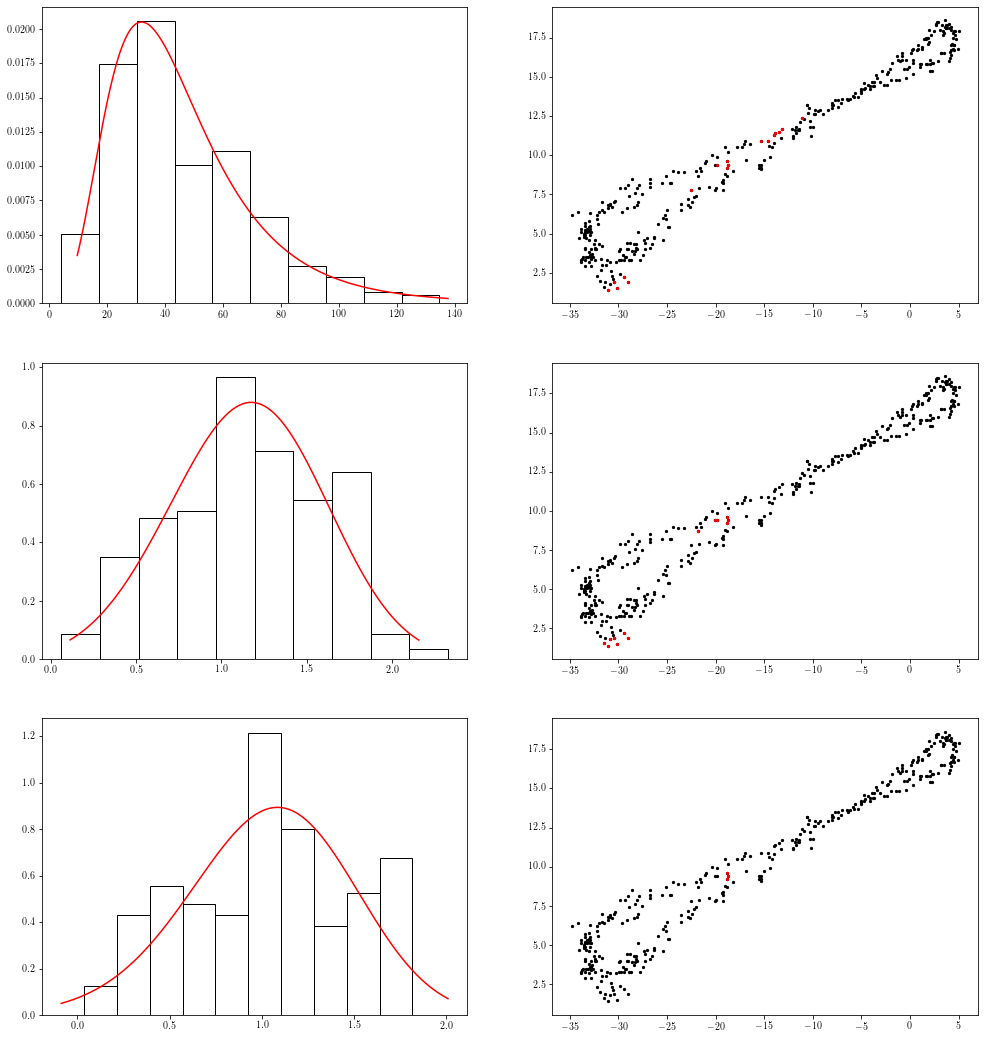

In [79]:
analysis_outliers(sample, dist1='ncf', dist2='powerlognorm', dist3='loggamma', filename="no-noise.pdf")

### Damaged Sample
Add noise to the original sample.

In [82]:
# Damage data
damaged_sample = sample.copy()
indexes = np.random.randint(sample.shape[1] - 1, size=30)
for index in indexes:
    rand = np.random.random()
    if rand < 0.5:
        damaged_sample[0, index] += np.random.normal(10, 0.5)
    else:
        damaged_sample[1, index] += np.random.normal(10, 0.5)

<Figure size 432x288 with 0 Axes>

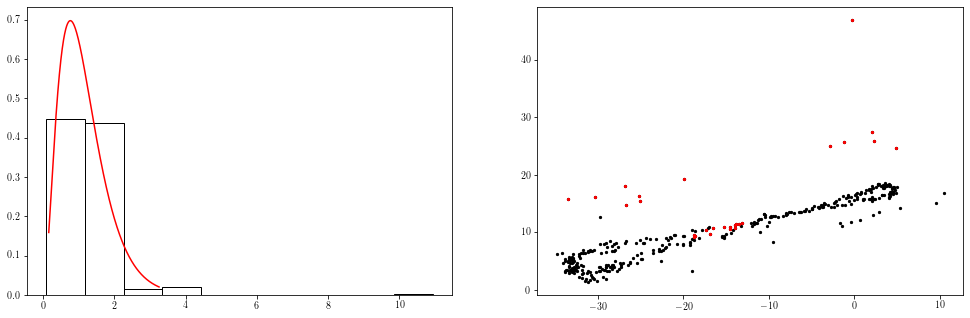

In [83]:
# Create outliers
non_robust(damaged_sample, filename="with-noise.pdf")

<Figure size 432x288 with 0 Axes>

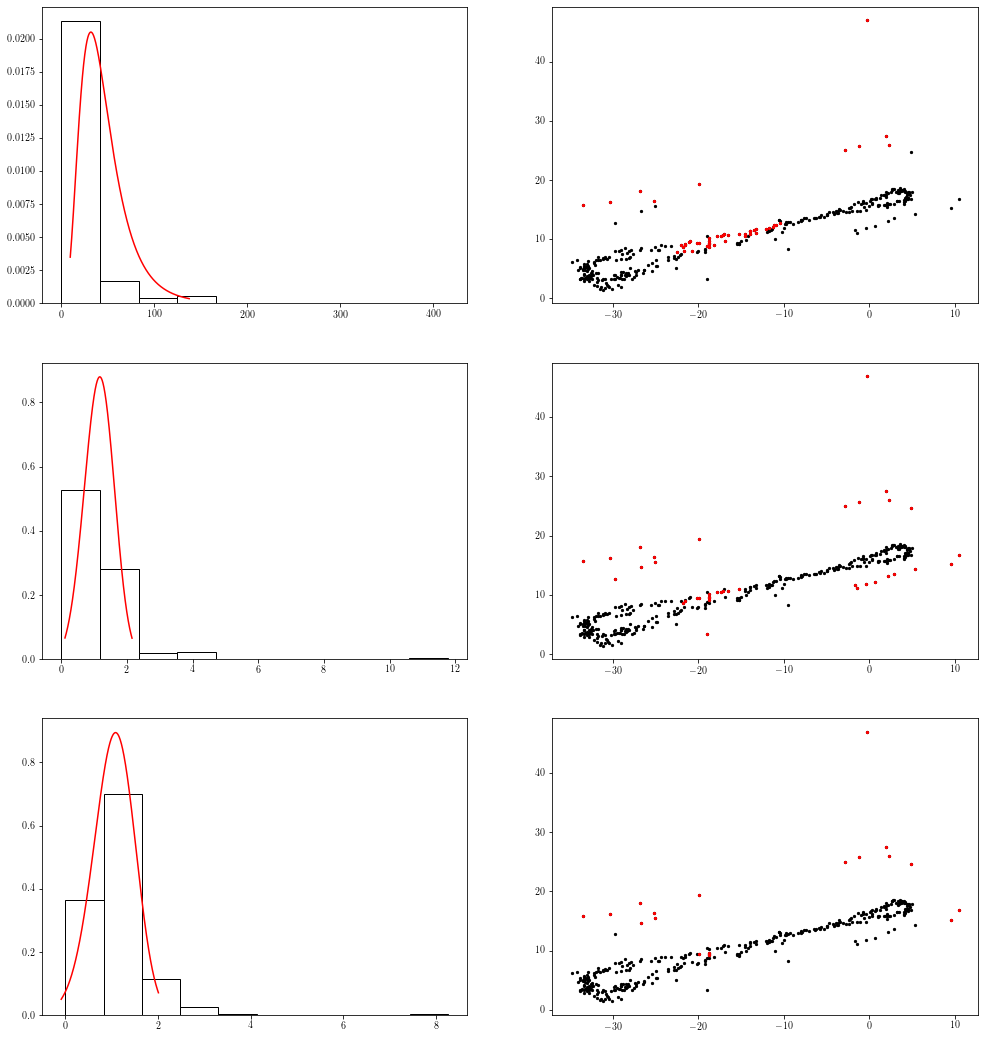

In [85]:
# Parameters obtained in last fitting
params1 = [0.01687548831480742, 17.239695538286078, 
           26.541605824072157, -0.16212434800608705,
           0.026204105994287116]
params2 = [543.7709069217824, 0.6214705751743547, 
           -0.9375471875010688, 13.662467507857233]
params3 = [20.07659805815092, -4.88556187496933, 
           1.9903081462053662]

analysis_outliers(damaged_sample, dist1='ncf', params1=params1, 
                  dist2='powerlognorm', params2=params2, 
                  dist3='loggamma', params3=params3,
                  filename="with-noise.pdf", fitting=False)

## Bernoulli
Generating sample of bernoulli data.

In [86]:
# Generation of Bernoulli Data
power = list(range(3, 16))
ns = [2**i for i in power]
bns = []
for n in ns:
    bns.append(st.bernoulli.rvs(0.2, size=n))

Obtaining prediction bands for the value of $p$.

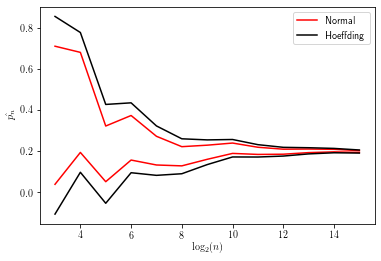

In [87]:
# Analysis
alpha = 0.05
z_alpha = st.norm.ppf(1 - alpha / 2)

# Finding bands
lower = []
upper = []

lower_alt = []
upper_alt = []
for bn in bns:
    p_hat = bn.mean()
    upper.append(p_hat + z_alpha * np.sqrt((p_hat * (1 - p_hat) / len(bn))))
    lower.append(p_hat - z_alpha * np.sqrt((p_hat * (1 - p_hat) / len(bn))))
    
    upper_alt.append(p_hat + np.sqrt(np.log(2 / alpha) / (2 * len(bn))))
    lower_alt.append(p_hat - np.sqrt(np.log(2 / alpha) / (2 * len(bn))))

# Plotting bands
plt.plot(power, upper, 'r')
plt.plot(power, lower, 'r', label="Normal")

plt.plot(power, upper_alt, 'k')
plt.plot(power, lower_alt, 'k', label="Hoeffding")
plt.legend()
plt.xlabel("$\log_2(n)$")
plt.ylabel("$\hat{p_n}$")

plt.savefig(dir_fig("bernoulli_bands.pdf"), bbox_inches='tight')
plt.show()

## ECDF Prediction bands
Generate normal sample

In [88]:
# Generate normal observation
obs = np.random.normal(size=(100, 1000))

### Method to analyze bands

In [99]:
# Plotting bands
def plot_bands(ecdfs, max_index, min_index, uppers, lowers, distribution, filename):
    # Plotting
    ecdf_max = ecdfs[max_index]
    upper_max = uppers[max_index]
    lower_max = lowers[max_index]
    plt.plot(ecdf_max.x, upper_max, 'k', alpha=0.3)
    plt.plot(ecdf_max.x, lower_max, 'k', alpha=0.3)
    plt.plot(ecdf_max.x, distribution.cdf(ecdf_max.x), 'k')
    plt.savefig(dir_fig("max_" + filename))
    plt.show()
    plt.clf()
    
    ecdf_min = ecdfs[min_index]
    upper_min = uppers[min_index]
    lower_min = lowers[min_index]
    plt.plot(ecdf_min.x, upper_min, 'k', alpha=0.3)
    plt.plot(ecdf_min.x, lower_min, 'k', alpha=0.3)
    plt.plot(ecdf_min.x, distribution.cdf(ecdf_min.x), 'k')
    plt.savefig(dir_fig("min_" + filename))
    plt.show()

# Analyzing bands
def analyze_bands(obs, alpha, distribution, filename):
    # Calculate each band
    epsilon = np.sqrt(1 / (2 * obs.shape[0]) * np.log(2 / alpha))
    uppers = []
    lowers = []
    counts = []
    ecdfs = []
    for i in range(obs.shape[1]):
        ecdf = ECDF(obs[:, i])
        ecdfs.append(ecdf)
        lower = np.zeros(len(ecdf.y))
        upper = np.zeros(len(ecdf.y))
        for j in range(len(ecdf.y)):
            lower[j] = max(ecdf.y[j] - epsilon, 0)
            upper[j] = min(ecdf.y[j] + epsilon, 1)
        
        uppers.append(upper)
        lowers.append(lower)
        count = 0
        for j in range(ecdf.x.size):
            x = ecdf.x[j]
            theo_y = distribution.cdf(x)
            if lower[j] <= theo_y <= upper[j]:
                count += 1
        counts.append(count)
    
    # Finding best and worst scenario
    counts = np.array(counts)
    max_index = np.argmax(counts)
    min_index = np.argmin(counts)
    
    # All closed
    num = counts[counts == obs.shape[0]]
    results = {"CDF enclosed by bands": len(num)}
    print_results(results)
    plot_bands(ecdfs, max_index, min_index, uppers, lowers, distribution, filename)

CDF enclosed by bands   7


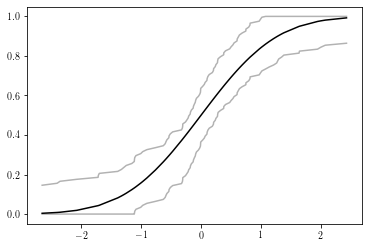

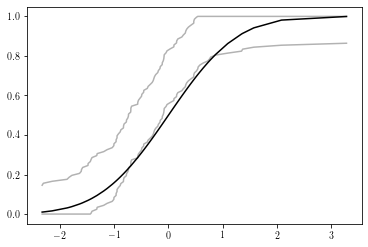

In [100]:
analyze_bands(obs, 0.05, st.norm, "normal_bands.pdf")

Generate sample with distribution cauchy.

In [97]:
# Generate cauchy observations
obs_cauchy = st.cauchy.rvs(size=(100, 1000))

CDF enclosed by bands   8


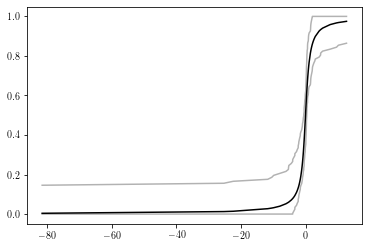

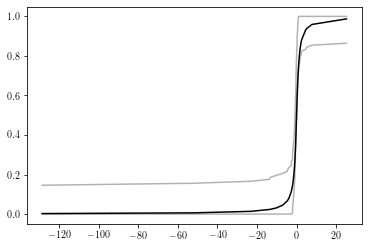

In [101]:
analyze_bands(obs_cauchy, 0.05, st.cauchy, "cauchy_bands.pdf")

## Influence function
Create function to calculate statistic and series.

In [108]:
def pearson(series):
    cov = np.cov(series, ddof=0)
    return cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])

# Read data 
lsat = "576 635 558 578 666 580 555 661 651 605 653 575 545 572 594".split(" ")
gpa = "3.39 3.30 2.81 3.03 3.44 3.07 3.00 3.43 3.36 3.13 3.12 2.74 2.76 2.88 3.96".split(" ")

series = np.array([lsat, gpa], dtype=np.float)

In [111]:
# Bootstrap with normal method
_, add = bootstrap(series, 1000, pearson, multi=True)

# Calculate influence function
means = np.mean(series, axis=1)
cov = np.cov(series, ddof=0)
vars_vir = series.copy()
for i in range(series.shape[0]):
    for j in range(series.shape[1]):
        vars_vir[i, j] = (vars_vir[i, j] - means[i]) / np.sqrt(cov[i, i])
x_vir = vars_vir[0, :]
y_vir = vars_vir[1, :]
L_xy = np.multiply(x_vir, y_vir) - 0.5 * pearson(series) * (x_vir ** 2 + y_vir ** 2)


# Calculate interval with third method
interval, _ = bootstrap(series, 1000, pearson, method=2, se_boot=np.sqrt(add['vboot']), multi=True)

# Print results
results = {"Pearson of series": pearson(series),
           "Variance Bootstrap": np.sqrt(add['vboot']),
           "Variance Jackknife": np.sqrt(jackknife_var(series, pearson, multi=True)),
           "Variance Influence": (L_xy ** 2).sum() / len(L_xy),
           "Variance interval": interval}
print_results(results)

Pearson of series    0.5459189161795887
Variance Bootstrap   7.951863425268428e-17
Variance Jackknife   0.017618204233666706
Variance Influence   0.4731649895821961
Variance interval    (0.5459189161795875, 0.5459189161795885)
